# 1. read data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *

In [2]:
ba_mcad = anndata.read_h5ad("../../02.clustering/02.5K/BA.All.TSNE.mcad")
ba_meta = pd.read_csv('../../02.clustering/02.5K/cell2cluster.csv')
ba_mcad = ba_mcad[ba_meta['cell'].to_list()]

In [3]:
ctrl_mcad = anndata.read_h5ad("../../../07.Ctrl/HIVpre_Flupre_Ctrl.withTSNE.h5ad")
ctrl_meta = pd.read_csv("../../../07.Ctrl/ControlCell2cluster.csv")
ctrl_mcad = ctrl_mcad[ctrl_meta['cell'].to_list()]

/tmp/ipykernel_1698720/1920901670.py:2: DtypeWarning: Columns (2,42,43,44,45,50,51,52,53,55,56,58,60,62,64,65,66,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  ctrl_meta = pd.read_csv("../../../07.Ctrl/ControlCell2cluster.csv")


In [4]:
mcad = anndata.concat([ba_mcad, ctrl_mcad])

In [5]:
id2cohort = dict(zip(ba_mcad.obs.index, ba_mcad.obs['Frequency']))

In [6]:
mcad.obs['Frequency'] = [id2cohort[x] if x in id2cohort else 'Ctrl' for x in mcad.obs.index]

In [7]:
id2mCG = dict(zip(ba_mcad.obs.index, ba_mcad.obs['mCGFrac']))
id2mCG.update(dict(zip(ctrl_mcad.obs.index, ctrl_mcad.obs['mCG_level'])))

In [8]:
mcad.obs['mCG_level'] = [id2mCG[x] for x in mcad.obs.index]

# 2.0 Clustering

In [9]:
pc_cutoff = 0.1

resolution = 1

In [10]:
lsi(mcad, algorithm='arpack', obsm='X_pca')
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=False)
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()

43 components passed P cutoff of 0.1.


In [11]:
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:, :32]
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

# T-SNE

In [12]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [13]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [14]:
mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

In [15]:
mcad = mcad[mcad.obs['cell_type'] != 'Other-cell']

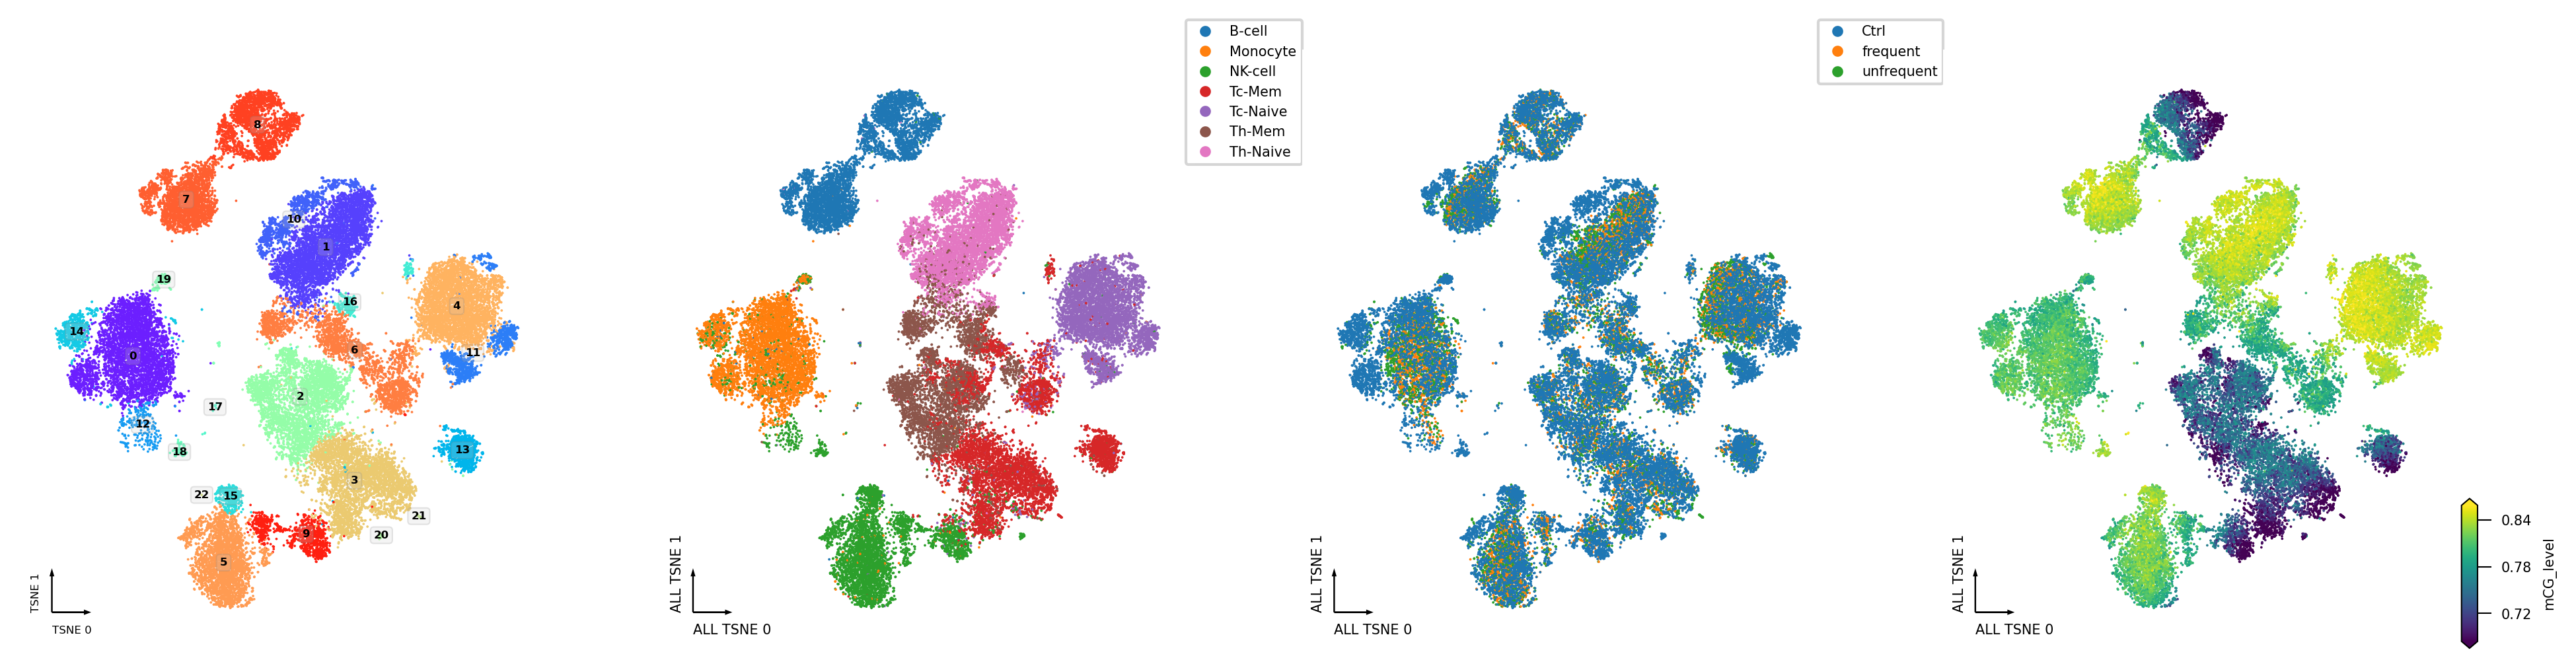

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='all_tsne', hue='Frequency', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='all_tsne', hue='mCG_level', labelsize=5)
plt.savefig('All_cluster.pdf')

In [17]:
leiden2celltype = {5: 'NK-cell2',
                   15: 'NK-cell2',
                   9: 'NK-cell1',
                  7: 'B-Naive',
                  8: 'B-Mem'}

In [18]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['leiden'])] if int(row['leiden']) in leiden2celltype else row['cell_type'], axis=1)

/tmp/ipykernel_1698720/739378038.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['leiden'])] if int(row['leiden']) in leiden2celltype else row['cell_type'], axis=1)


In [20]:
mcad.obs['Age'] = mcad.obs['Age'].astype(str)

In [21]:
mcad.write_h5ad('BA.Ctrl.All.TSNE.Annotation.mcad')

In [22]:
mcad.obs.to_csv("cell2cluster.csv")

In [6]:
import matplotlib
matplotlib.rc("pdf", fonttype=42)

In [2]:
metadata = pd.read_csv("cell2cluster.csv")

/tmp/ipykernel_3245524/1990708883.py:1: DtypeWarning: Columns (72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("cell2cluster.csv")


In [3]:
metadata = metadata[metadata['cell_type'] != 'Other-cell']

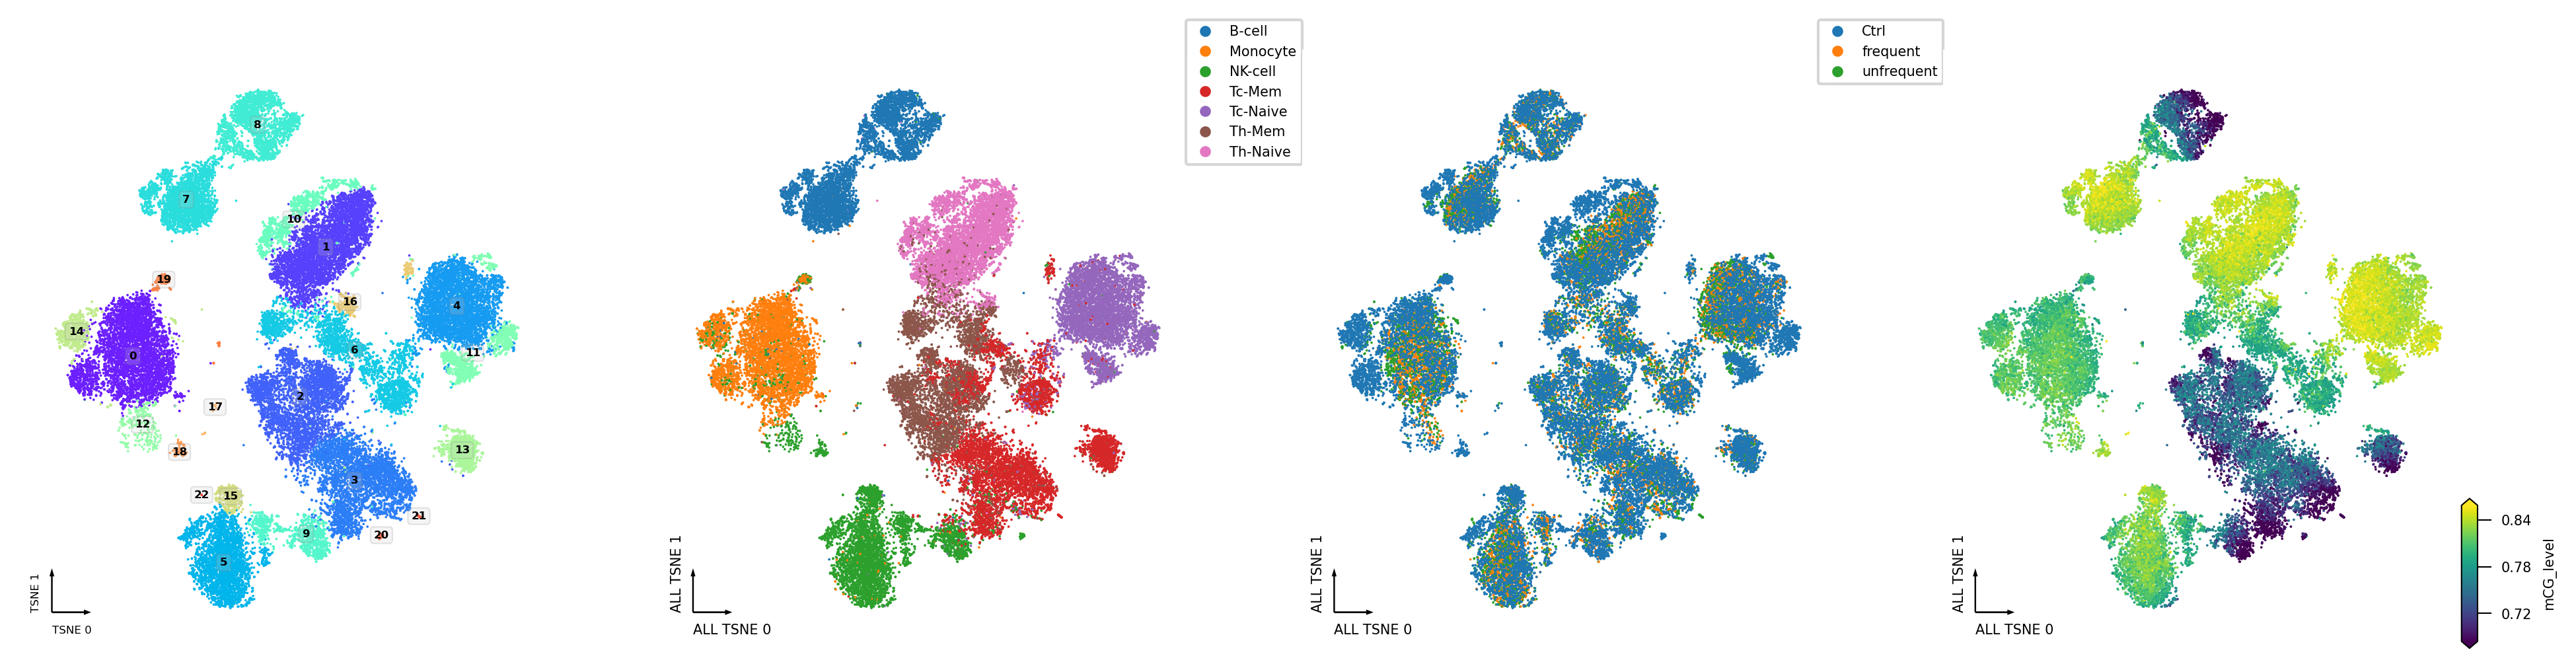

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=metadata, ax=axes[0], coord_base='tsne', hue='leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=metadata, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=metadata, ax=axes[2], coord_base='all_tsne', hue='Frequency', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=metadata, ax=axes[3], coord_base='all_tsne', hue='mCG_level', labelsize=5)
plt.savefig("BA_All_cluster.pdf")

In [7]:
from collections import defaultdict, Counter

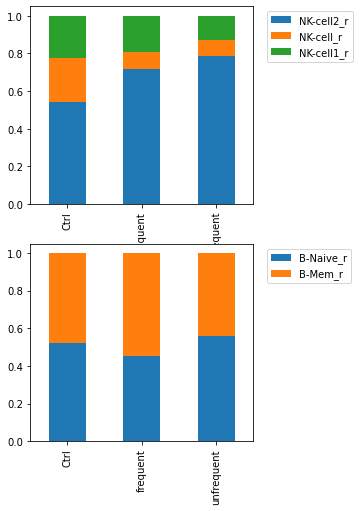

In [8]:
fig, axes = plt.subplots(2,1, figsize=(4,8))
count_list = list()
for i, celltype in enumerate(['NK-cell', 'B-cell']):
    cell_df = metadata[metadata['cell_type'] == celltype]
    count_dict = cell_df[['Frequency', 'annotation']].value_counts().to_dict()
    
    cell_counter = defaultdict(Counter)
    for (cond, cell) in count_dict:
        if count_dict[(cond, cell)] < 50:
            continue
        cell_counter[cond][cell] = count_dict[(cond, cell)]
        cell_counter[cond]['total'] += count_dict[(cond, cell)]
    cell_counter_df = pd.DataFrame.from_dict(cell_counter, orient='index')
    count_list.append(cell_counter_df)
    for cell in cell_counter_df.columns:
        if cell == 'total':
            continue
        cell_counter_df[f'{cell}_r'] = cell_counter_df.apply(lambda row: row[cell] / row['total'], axis=1)
    cell_counter_df[[x for x in cell_counter_df.columns if x.endswith("_r")]].sort_index().plot.bar(stacked=True, ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('MRSA_B-NK_ratio.pdf')

In [9]:
data_df = pd.concat(count_list, axis=1)

In [10]:
data_df

,NK-cell2,total,NK-cell,NK-cell1,NK-cell2_r,NK-cell_r,NK-cell1_r,B-Naive,total,B-Mem,B-Naive_r,B-Mem_r
Ctrl,1555,2868,666,647,0.542190,0.232218,0.225593,1441,2765,1324,0.521157,0.478843
unfrequent,1044,1329,112,173,0.785553,0.084274,0.130173,717,1279,562,0.560594,0.439406
frequent,765,1066,98,203,0.717636,0.091932,0.190432,468,1033,565,0.453049,0.546951


In [11]:
from scipy.stats import chi2_contingency

In [12]:
chi2_contingency(data_df.loc[['Ctrl','unfrequent','frequent'], ['B-Mem', 'B-Naive']])

(26.84322973758271,
 1.4827458741592957e-06,
 2,
 array([[1334.84636596, 1430.15363404],
        [ 617.45696277,  661.54303723],
        [ 498.69667126,  534.30332874]]))

In [13]:
chi2_contingency(data_df.loc[['Ctrl','unfrequent','frequent'], ['NK-cell2', 'NK-cell1', 'NK-cell']])

(303.6832450839359,
 1.738852908997338e-64,
 4,
 array([[1833.16587498,  557.4698841 ,  477.36424093],
        [ 849.46912407,  258.32547976,  221.20539616],
        [ 681.36500095,  207.20463614,  177.43036291]]))